In [125]:
import numpy as np
import warnings
warnings.simplefilter('ignore')
import pandas as pd
%pylab inline
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.regression import mean_squared_error
from sklearn.metrics import classification_report,r2_score, roc_curve,roc_auc_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression, LassoCV, Lasso 

Populating the interactive namespace from numpy and matplotlib


In [70]:
xls_file = pd.ExcelFile('retail_vol_ccy_w_rt.xlsx')
df = xls_file.parse('Total')
df.head()

,Date,vol_tot,vol_rub,vol_ccy,expo_tot,expo_rub,expo_ccy,npl_tot,npl_rub,npl_ccy,...,wage,d_wage,rt3m,d_rt3m,d_GPD,f_dec,f_jan,unp,cpi,d_cpi
0,2009-04-01,456779.2,424697.2,32082.0,3848399.0,3341053.6,507345.4,180597.6,155980.0,24617.6,...,18009,0.000000,16.53,0.00,-0.035002,0,0,8.3,100.7,0.0
1,2009-05-01,228701.0,216410.3,12290.7,3791289.5,3300033.5,491256.0,193421.9,166553.5,26868.4,...,18007,-0.000111,16.04,-0.49,-0.035002,0,0,8.3,100.6,-0.1
2,2009-06-01,221268.3,212818.6,8449.7,3722873.1,3266609.3,456263.8,202671.2,176069.2,26602.0,...,19247,0.068862,12.49,-3.55,-0.035002,0,0,8.3,100.6,0.0
3,2009-07-01,266435.9,256395.6,10040.3,3683033.9,3232124.6,450909.3,209446.2,182799.5,26646.7,...,18872,-0.019484,11.81,-0.68,-0.065562,0,0,8.3,100.6,0.0
4,2009-08-01,232492.2,221958.4,10533.8,3667260.9,3218173.3,449087.6,217713.4,190062.3,27651.1,...,18335,-0.028455,11.89,0.08,-0.065562,0,0,8.3,100.0,-0.6


In [107]:
df['f_dec'].value_counts()

0    95
1     8
Name: f_dec, dtype: int64

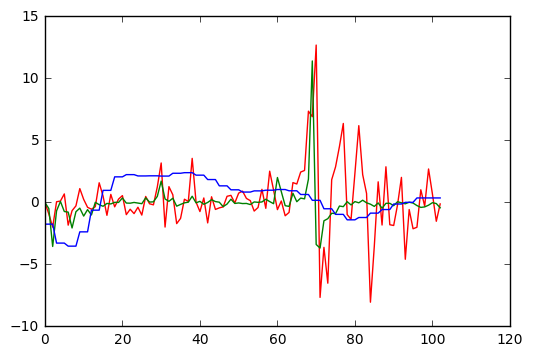

In [123]:
plt.plot(df['d_rubusd'] ,c = 'red')
plt.plot(df['d_rt3m'],c = 'green')
#plt.plot(df['d_wage']*20,c = 'black')
plt.plot(df['d_GPD']*50,c = 'blue')
plt.show()

In [73]:
predictors = list(set(['d_rubusd','d_wage','d_rt3m','d_GPD','f_dec','f_jan','unp' ,'d_cpi']))#'wage',

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x07121930>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0DBB92D0>]], dtype=object)

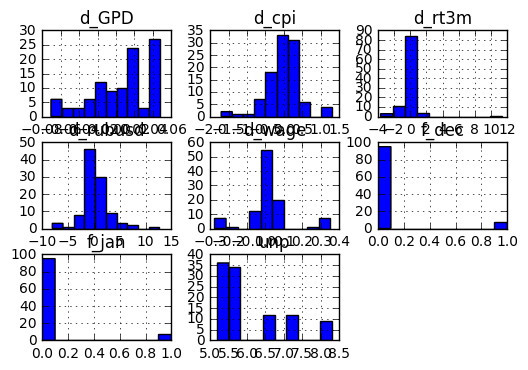

In [74]:
df[predictors].hist()

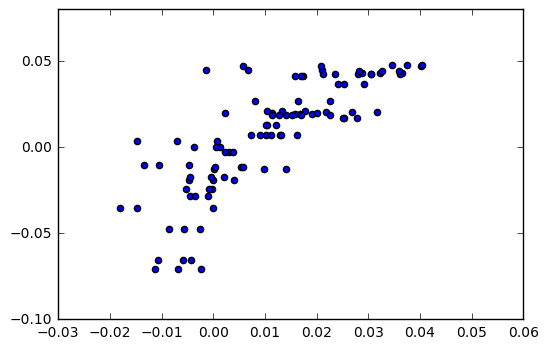

In [124]:
fig, ax = plt.subplots()
ax.scatter(df['portf_gr'], df['d_GPD'])

In [75]:
#Пока берем в качестве обучающей выборки всю выборку
#X_train = df[predictors]
#y_train = df['portf_gr']

#X_test = df[predictors].copy()
#y_test = df['portf_gr'].copy()

Смотрим на корреляции признаков

In [76]:
corr = df[predictors].corr()
corr

,d_wage,d_GPD,d_cpi,d_rt3m,f_jan,d_rubusd,f_dec,unp
d_wage,1.000000,0.000807,-0.119367,-0.174949,-0.675175,0.021355,0.734719,0.064783
d_GPD,0.000807,1.000000,0.024816,0.216277,0.016195,0.013677,-0.005812,-0.455573
d_cpi,-0.119367,0.024816,1.000000,0.426735,0.385821,0.090478,0.143649,-0.017277
d_rt3m,-0.174949,0.216277,0.426735,1.000000,0.314184,0.292862,0.061294,-0.194898
f_jan,-0.675175,0.016195,0.385821,0.314184,1.000000,0.088118,-0.084211,-0.068288
d_rubusd,0.021355,0.013677,0.090478,0.292862,0.088118,1.000000,0.162036,-0.104354
f_dec,0.734719,-0.005812,0.143649,0.061294,-0.084211,0.162036,1.000000,0.038185
unp,0.064783,-0.455573,-0.017277,-0.194898,-0.068288,-0.104354,0.038185,1.000000


Разбиваем на обучающую и тестовую выборки

In [126]:
X_train,X_test,y_train,y_test =train_test_split(df[predictors],df['portf_gr'],random_state=0)

Случайный лес

In [127]:
forest = RandomForestRegressor(n_estimators=1000, max_depth = 5,
                                random_state=42).fit(X_train, y_train)

features = pd.DataFrame(forest.feature_importances_,
                        index=X_train.columns,columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)
test_pred = forest.predict(X_test)
features

,Importance
d_GPD,0.779910
d_rt3m,0.085520
d_rubusd,0.065795
unp,0.027062
d_wage,0.026536
d_cpi,0.014574
f_jan,0.000360
f_dec,0.000242


In [128]:
forest.score(X_train, y_train)

0.95931331809173692

In [129]:
print(mean_squared_error(forest.predict(X_train), y_train))
print(abs(np.mean(cross_val_score(forest, X_train, y_train, scoring='mean_squared_error', n_jobs=-1))))

7.53248778974e-06
5.89666923579e-05


Нормируем выборку

In [130]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [131]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_train_scaled.head()

,d_wage,d_GPD,d_cpi,d_rt3m,f_jan,d_rubusd,f_dec,unp
0,-0.104097,-2.594443,-0.013809,-0.566491,-0.316228,-0.844956,-0.290701,2.575556
1,-2.271832,0.597887,1.049476,-0.003291,3.162278,-0.321622,-0.290701,-0.554221
2,0.205570,-0.042218,0.411505,-0.193371,-0.316228,-0.909251,-0.290701,-0.512644
3,0.025831,-1.201083,0.198848,0.024869,-0.316228,-0.524725,-0.290701,-0.478895
4,0.286952,0.403634,-0.651780,-0.200411,-0.316228,-0.560724,-0.290701,-0.889554


In [136]:
linregsc = LinearRegression(n_jobs=-1)
linreg = LinearRegression(n_jobs=-1)
linregsc.fit(X_train_scaled, y_train)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [138]:
print(mean_squared_error(linreg.predict(X_train_scaled), y_train))
#print(mean_squared_error(linreg.predict(X_train), y_train))
print(r2_score(y_train,linregsc.predict(X_train_scaled)))
print(r2_score(y_train,linreg.predict(X_train)))
print(r2_score(y_test,linregsc.predict(X_test_scaled)))

0.134624970323
0.704075520724
0.704075520724
0.545121013863


In [140]:
linreg_coef = pd.DataFrame(np.c_[linregsc.coef_, np.abs(linregsc.coef_)], index=df[predictors].columns, 
                           columns=['Coeff.', 'Coeff.abs'])
linreg_coef.sort_values(by='Coeff.abs', ascending=False)

,Coeff.,Coeff.abs
d_GPD,0.011551,0.011551
d_wage,-0.004505,0.004505
f_jan,-0.003823,0.003823
f_dec,0.002146,0.002146
d_cpi,0.002132,0.002132
unp,0.001246,0.001246
d_rt3m,-0.000804,0.000804
d_rubusd,0.000487,0.000487


In [141]:
test_l_pred = linreg.predict(X_test)

In [142]:
test_l_pred_sc = linregsc.predict(X_test_scaled)

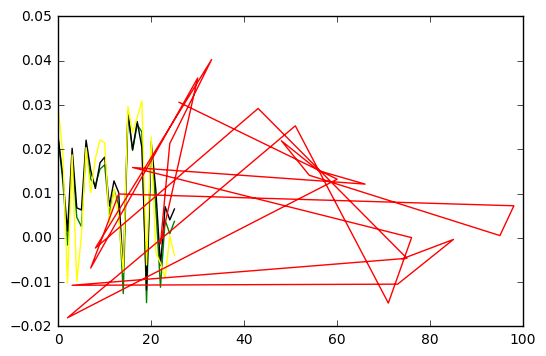

In [144]:
plt.plot(test_l_pred, label='linreg', c='green')
plt.plot(test_l_pred_sc, label='Scaled', c='black')
plt.plot(test_pred, label='forest', c='yellow')
plt.plot(y_test, label='Actual', c='red')
plt.show()    
    

In [67]:
lasso1 = Lasso(alpha=0.01, random_state=7)
#lasso1.fit(X_train_scaled, y_train)
lasso1.fit(X_train, y_train)
lasso1.coef_

array([ 0.        , -0.00085879, -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.00028675])

In [68]:
lasso1_coef = pd.DataFrame(np.c_[lasso1.coef_, np.abs(lasso1.coef_)], index=df[predictors].columns, 
                           columns=['Coeff.', 'Coeff.abs'])
lasso1_coef.sort_values(by='Coeff.abs', ascending=False)

,Coeff.,Coeff.abs
rt3m,-0.000859,0.000859
rubusd,-0.000287,0.000287
d_dec,0.000000,0.000000
wage_gr,-0.000000,0.000000
d_jan,0.000000,0.000000
cpi,-0.000000,0.000000
dGPD,0.000000,0.000000
unp,-0.000000,0.000000


In [ ]:
alphas = np.linspace(0.1, 10, 200)
lasso_cv = LassoCV(alphas=alphas, 
                   cv=5, random_state=7)
lasso_cv.fit(X_train_scaled, y_train)

In [ ]:
lasso_cv_coef = pd.DataFrame(np.c_[lasso_cv.coef_, np.abs(lasso_cv.coef_)], index=df[predictors].columns,  
                           columns=['Coeff.', 'Coeff.abs'])
lasso_cv_coef.sort_values(by='Coeff.abs', ascending=False)

In [72]:
#print(mean_squared_error(lasso_cv.predict(X_train_scaled), y_train))
print(mean_squared_error(lasso_cv.predict(X_train), y_train))

0.000203245084452


In [ ]:
####пример модели
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation


def preProcess():
    df= pd.read_csv('C:/Users/X/Desktop/Managerial_and_Decision_Economics_2013_Video_Games_Dataset.csv',encoding ='ISO-8859-1')
    #drop non EA
    df = df[df['EA'] ==1]
    #change categorical variables
    le = LabelEncoder()
    nonnumeric_columns=['Console','Title','Publisher','Genre']
    for feature in nonnumeric_columns:
        df[feature] = le.fit_transform(df[feature])
    #set dataset and target variables
    dataset =df.ix[:, df.columns != 'US Sales (millions)']
    target = df['US Sales (millions)']

    trainx, testx, trainy, testy = cross_validation.train_test_split(
        dataset, target, test_size=0.3, random_state=0)
    #attempt to fix error?
    trainx=np.array(trainx)
    trainy = np.asarray(trainy, dtype="float")
    return trainx,testx,trainy,testy

def classifier():
    model =  ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
    model.fit(trainx,trainy)
    return model.score(testx,testy)


trainx,testx,trainy,testy=preProcess()